In [ ]:
#https://github.com/bentrevett/pytorch-sentiment-analysis
#https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/6%20-%20Transformers%20for%20Sentiment%20Analysis.ipynb

In [ ]:
pip install transformers

     |████████████████████████████████| 2.1MB 19.1MB/s 
     |████████████████████████████████| 901kB 52.9MB/s 
     |████████████████████████████████| 3.3MB 51.5MB/s 


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import random
import numpy as np
import pandas as pd
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
import time
from sklearn.metrics import classification_report
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# specify GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#df_all = pd.read_csv('all-data.csv',encoding='latin-1')
df_all = pd.read_csv('/content/drive/My Drive/content/all-data.csv', encoding = 'latin-1', header=None )
df_all.columns = ["sentiment", "text"]

In [ ]:
df_all.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
#df_all = df_all[['text','sentiment']]
dic = {'negative' : 0, 'neutral': 1, 'positive': 2}
df_all['sentiment']= df_all['sentiment'].replace(dic).astype('int64')
df_all.head()

,sentiment,text
0,1,"According to Gran , the company has no plans t..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


In [ ]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df_all['text'], df_all['sentiment'], 
                                                                    random_state=45, 
                                                                    test_size=0.3, 
                                                                    stratify=df_all['sentiment'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=45, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [ ]:
from transformers import AutoModel, BertTokenizerFast
# import BERT-base pretrained model
#bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
# t
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 40,
    padding='longest',
    truncation=True
)

In [ ]:
## convert lists to tensors
test_seq = torch.tensor(tokens_test['input_ids'])[:32]
test_mask = torch.tensor(tokens_test['attention_mask'])[:32]
test_y = torch.tensor(test_labels.tolist())[:32]

In [ ]:
#define a batch size
batch_size = 32

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for test set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size, drop_last=True)

In [ ]:
#import torch.nn as nn
#import torch.nn.functional as F
from torch.autograd import Variable

# reference source: https://www.programmersought.com/article/31037125394/
class AttnDPCNN(nn.Module):

    def __init__(self, batch_size,seq_len,embedding_dim,output_size_linear, 
                 cnn_channel_size, cnn_kernel_size=(3,1),cnn_padding=0, cnn_stride=1, attn_nodes_per_layer = 10):

        super(AttnDPCNN, self).__init__()
        #self.bert=bert
        self.attn_nodes_per_layer = attn_nodes_per_layer
        self.channel_size = cnn_channel_size
        self.output_size_linear = output_size_linear
        self.cnn_kernel_size = cnn_kernel_size
        self.padding = cnn_padding
        self.stride = cnn_stride
        #self.vocab_size = vocab_size
        self.embed_dim = embedding_dim
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.maps = {}
        self.get_maps = False
        
        self.collect_out_softmax = torch.zeros(1,1).to(device)
        self.collect_out_attn = torch.zeros(self.batch_size,self.attn_nodes_per_layer).to(device)
        
        #self.embed = nn.Embedding(self.vocab_size, self.embed_dim)
        self.conv1 = nn.Conv2d(1,  self.channel_size, (3,self.embed_dim), stride = 1) # embed_dim becomes 1
        self.conv2 = nn.Conv2d(self.channel_size,  self.channel_size,  
                                kernel_size=self.cnn_kernel_size, padding=0,
                               stride = self.stride)
        self.padding1 = nn.ZeroPad2d((0, 0, 1, 1))  # top bottom
        self.padding2 = nn.ZeroPad2d((0, 0, 0, 1))  # bottom
        self.max_pool = nn.MaxPool2d(kernel_size=(3, 1), stride=2)      
        
        self._repeat_block = nn.Sequential( # input [batch_size, num_filters, seq_len-3+1, 1]
                    nn.ZeroPad2d((0, 0, 1, 1)), # [batch_size, num_filters, seq_len, 1]
                    nn.ReLU(),
                    nn.Conv2d(self.channel_size,  self.channel_size,   # [batch_size, num_filters, seq_len-3+1, 1]
                                kernel_size=self.cnn_kernel_size, padding=0,
                               stride = self.stride),
                    nn.ZeroPad2d((0, 0, 1, 1)), # [batch_size, num_filters, seq_len, 1]
                    nn.ReLU(),
                    nn.Conv2d(self.channel_size,  self.channel_size,  # [batch_size, num_filters, seq_len-3+1, 1]
                                kernel_size=self.cnn_kernel_size, padding=0,
                               stride = self.stride),
            )
        
        
        # To get variying attention weights for 1) softmax output 2) 10 representing features
        self.num_repeat_blocks, self.size_repeat_blocks_list = self.dividible(2)
        # self.weight_softmax_list, self.weight_attn_list = self.getWeights_init()
        
        self.counter=0
        
        # Drop probability
        self.dropout = nn.Dropout(p=0.2)
        # Last linear layer (FC)
        #self.linear1 = nn.Linear(self.num_repeat_blocks*self.attn_nodes_per_layer,self.output_size_linear)
        self.linear1 = nn.Linear(self.channel_size,self.output_size_linear)
          
    def repeat_block(self, x): # input [batch_size, num_filters, seq_len-3+1, 1]
        x = self.padding2(x) # [batch_size, num_filters, seq_len-1, 1] -> seq_len-3+1+1 = seq_len-1
        #print('padding')
        x1 = self.max_pool(x)  # [batch_size, num_filters, (seq_len-1) // 3, 1 //1] -> seq_len-3+1+1 = seq_len-1
        #print('x1',x1.shape)
        # conv block
        x2 = self._repeat_block(x1)
        #print('x2',x2.shape)
        # Identity addition
        #x = x1 + x2
        #print('x1+x2',x.shape)
        return x1,x2

    def forward(self, x):
        
        self.counter =0

        #embed = self.bert(sent_id, attention_mask=mask)
        #x = embed['last_hidden_state'].unsqueeze(1) # [batch_size, 1, seq_len, embedding_dim]
        x = self.conv1(x)  # [batch_size, num_filters, seq_len-3+1, 1]
        #print(x.shape)
        x = self.padding1(x)  # [batch_size, num_filters, seq_len, 1]
        x = F.relu(x)
        x = self.conv2(x)  # [batch_size, num_filters, seq_len-3+1, 1]

        count=0
        while x.shape[2] >= 2: # till seq_len is 1
            #print("start x",x.shape)
            x_prev,x = self.repeat_block(x)  # [batch_size, num_filters,1,1] at the end
            #print("after pooling x",x.shape)
            seq = x.shape[2]

            ## DOT PRODUCT SELF ATTENTION
            query = x.clone().squeeze() # 32 x feature map x seq
            #print("query",query.shape)
            key = x.clone().squeeze() # 32 x feature map x seq
            #print("key",query.shape)
            value = x.clone().squeeze() # 32 x feature map x seq
            #print("value",value.shape)

            if len(query.shape) ==2:
              query = query.unsqueeze(2)
            if len(key.shape) ==2:
              key = key.unsqueeze(2)
            if len(value.shape) ==2:
              value = value.unsqueeze(2)

            # dot product
            dot_prod = torch.bmm(query.transpose(1,2),key)  # 32 x seq x seq
            #print("dp1",dot_prod[0,0,:])
            dot_prod = dot_prod / value.shape[1] # 32 x seq x seq
            #print("dot product", dot_prod.shape)

            softmax_out = torch.softmax(dot_prod, dim=1)
            #print(softmax_out[0,:,0].sum()) #== 1
            x = torch.bmm(value,softmax_out.transpose(1,2))

            x = x.reshape(self.batch_size, self.channel_size, seq).unsqueeze(3)
            x = x+x_prev
            #print("end x", x.shape)
            #break
            if self.get_maps:
              self.maps.update({count : softmax_out})
            count+=1

        ## FULLY CONNECTED ##
        # linear layer
        # output = final_collect_out_attn.reshape(x.shape[0], -1) # [batch_size, num_filters]
        output = x.reshape(x.shape[0], -1) # [batch_size, num_filters]
        # x = x.squeeze()  # [batch_size, num_filters]
        output = self.linear1(output)  # [batch_size, output size]
        output = self.dropout(output)
        return output
    
    def dividible(self,p):
        n=self.seq_len
        i = 0
        out=[]
        while n>=p:
            if i==0:
                n = (n-2)//2
               #n=n-2
               #out.append(n-1)
            else:
                n = n//2
                #out.append(n)
            i += 1
            out.append(n)
        return i,out
    
    def getWeights_init(self):
        weights_softmax_list = []
        weights_attn_list = []
        for i in range(self.num_repeat_blocks):
            # size_repeat_blocks_list contains various seq length
            #print('batch size', self.batch_size)
            #print('seq len', self.size_repeat_blocks_list[i])
            #print('channel size', self.channel_size)
            weights_softmax_list.append(Variable(torch.randn(1,self.batch_size*1*self.size_repeat_blocks_list[i]*self.channel_size)).to(device))
            weights_attn_list.append(Variable(torch.randn(self.attn_nodes_per_layer,1*self.size_repeat_blocks_list[i]*self.channel_size)).to(device)) # fix output features as 10
        return weights_softmax_list,weights_attn_list
            

In [ ]:
import pickle
filenamedpcnn = '/content/drive/My Drive/content/BertAttnsDPCNN_selfattention_False_finance_Exp5dpcnn.pkl'
filenamebert = '/content/drive/My Drive/content/BertAttnsDPCNN_selfattention_False_finance_Exp5bert.pkl'

bert = pickle.load(open(filenamebert, 'rb'))
dpcnn = pickle.load(open(filenamedpcnn, 'rb'))


In [ ]:
#dpcnn = AttnDPCNN(32,40,768, 3, 128) # batchsize, seq len, embed dim, classes, no of filters
dpcnn = dpcnn.to(device)
bert = bert.to(device)

TEST

In [ ]:
# function for evaluating the model
def test():
  
  print("\nEvaluating...")
  t0 = time.time()
  # deactivate dropout layers
  #model.eval() replace below?

  #load weights of best model
  #bpath = 'bert_saved_weights.pt'
  #bert.load_state_dict(bert.load(bpath))

  bert.eval()
  dpcnn.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []
  total_targets = []
  # iterate over batches
  for step,batch in enumerate(test_dataloader):
    if step == len(test_dataloader)-1:
      dpcnn.get_maps=True 
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = time.time() - t0
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      embed = bert(sent_id, attention_mask=mask)
      x = embed['last_hidden_state'].unsqueeze(1) # [batch_size, 1, seq_len, embedding_dim]
      preds = dpcnn(x)

      # compute the validation loss between actual and predicted values
      #loss = cross_entropy(preds,labels)

      #total_loss = total_loss + loss.item()

      preds = preds.detach().cpu()
      labels = labels.detach().cpu()

      total_preds.append(preds.numpy())
      total_targets.append(labels.numpy())
  # compute the validation loss of the epoch
  #avg_loss = total_loss / len(test_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  total_targets = np.concatenate(total_targets, axis=0)

  return total_preds, total_targets

In [ ]:
test_preds, test_targets = test()



Evaluating...


In [ ]:
test_preds2 = test_preds.argmax(axis=1)
test_preds2.shape

(32,)

In [ ]:
test_targets.shape

(32,)

In [ ]:
correct = []
wrong = []
for i,(target,pred) in enumerate(zip(test_targets,test_preds2)):
  if target == pred:
    correct.append(i)
  else:
    wrong.append(i)


In [ ]:
print(len(correct))
print(len(wrong))
print(len(dpcnn.maps))

27
5
5


In [ ]:
dpcnn.maps[0].shape


torch.Size([32, 19, 19])

In [ ]:
correct[0:5]

[0, 1, 2, 4, 5]

In [ ]:
wrong

[3, 8, 13, 16, 22]

In [ ]:
df1=test_labels.reset_index()
df2=test_text.reset_index()

Visualization of incorrect prediction with attention map - 1st example

In [ ]:
print(df1['sentiment'][13])
print(df2['text'][13])

1
Calls to the switchboard and directory services have decreased significantly since our employees now have up-to-date contact information from all their colleagues and customers on their phone and can place the call directly .


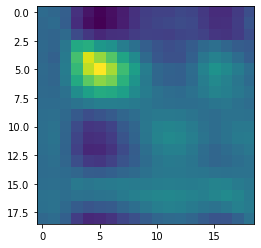

In [ ]:
maps = dpcnn.maps[0].cpu()
map = maps[13,:,:]

import matplotlib.pyplot as plt
plt.imshow(map)
#plt.colorbar()
plt.show()

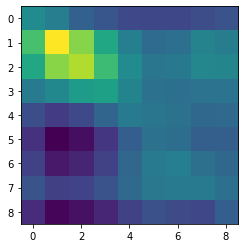

In [ ]:
maps = dpcnn.maps[1].cpu()
map = maps[13,:,:]

import matplotlib.pyplot as plt
plt.imshow(map)
plt.show()

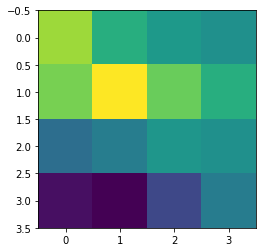

In [ ]:
maps = dpcnn.maps[2].cpu()
map = maps[13,:,:]

import matplotlib.pyplot as plt
plt.imshow(map)
plt.show()

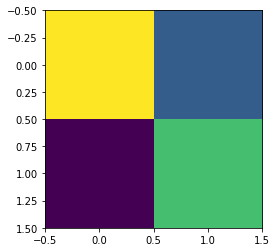

In [ ]:
maps = dpcnn.maps[3].cpu()
map = maps[13,:,:]

import matplotlib.pyplot as plt
plt.imshow(map)
plt.show()

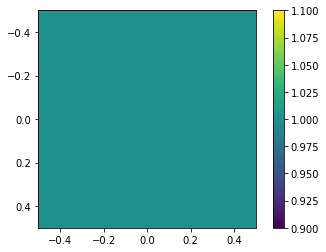

In [ ]:
maps = dpcnn.maps[4].cpu()
map = maps[13,:,:]

import matplotlib.pyplot as plt
plt.imshow(map)
plt.colorbar()
plt.show()

Visualization of correct prediction with attention map

In [ ]:
print(df1['sentiment'][1])
print(df2['text'][1])

1
The deal means that ten persons in three countries will transfer to Tieto .


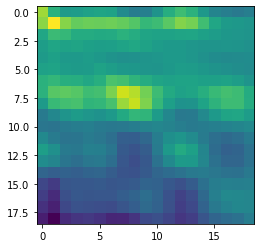

In [ ]:
maps = dpcnn.maps[0].cpu()
map = maps[1,:,:]

import matplotlib.pyplot as plt
plt.imshow(map)
plt.show()

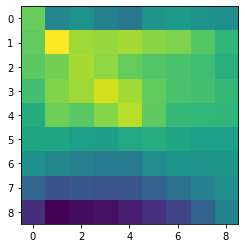

In [ ]:
maps = dpcnn.maps[1].cpu()
map = maps[1,:,:]

import matplotlib.pyplot as plt
plt.imshow(map)
plt.show()

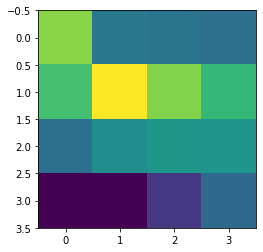

In [ ]:
maps = dpcnn.maps[2].cpu()
map = maps[1,:,:]

import matplotlib.pyplot as plt
plt.imshow(map)
plt.show()

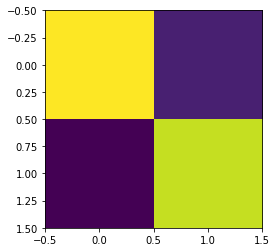

In [ ]:
maps = dpcnn.maps[3].cpu()
map = maps[1,:,:]

import matplotlib.pyplot as plt
plt.imshow(map)
plt.show()

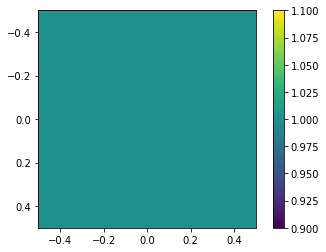

In [ ]:
maps = dpcnn.maps[4].cpu()
map = maps[1,:,:]

import matplotlib.pyplot as plt
plt.imshow(map)
plt.colorbar()
plt.show()